In [ ]:
! pwd

In [ ]:
! conda list | grep ctapipe
! conda list | grep ctlearn
! conda list | grep dl1-data-handler 
! conda list | grep pyirf

In [ ]:
! ls -l ../data/DL2_fullstats/

## Build IRF tool
This pyirf-based tool can be used to obtain the IRFs using the different settings. The help ($ build_irf -h) display various options.

In [ ]:
! build_irf -h

### Optimize for the best sensitivity
This configuration will optimize the IRF curves in each reco energy bin for the best sensitivity.

In [ ]:
! build_irf \
    --input ../data/DL2_fullstats/ \
    --pattern "LST1_*.h5" \
    --output ../data/IRFs/LST1_cleanedTRN_DeepCrab_theta_10.0_az_102.199_optimized_sensitivity \
    --energy_range 0.02 20.0 \
    --size_cut 50 

### Energy dependent 
This configuration will compute the IRF curves based on a specified gamma efficiency in each reco energy bin. IRF curves usually are smoother than optimizing each energy bin independently. 

In [ ]:
! build_irf \
    --input ../data/DL2_fullstats/ \
    --pattern "LST1_cleanedTRN_DeepCrab_theta_10.0_az_102.199_*.h5" \
    --output ../data/IRFs/LST1_cleanedTRN_DeepCrab_theta_10.0_az_102.199_gammaefficiency0.7 \
    --energy_range 0.02 20.0 \
    --size_cut 50 \
    --energy_dependent_gh_efficiency 0.7

### Plotting the IRFs
After the creation of the IRFs, one can plot the different curves from the fits file.

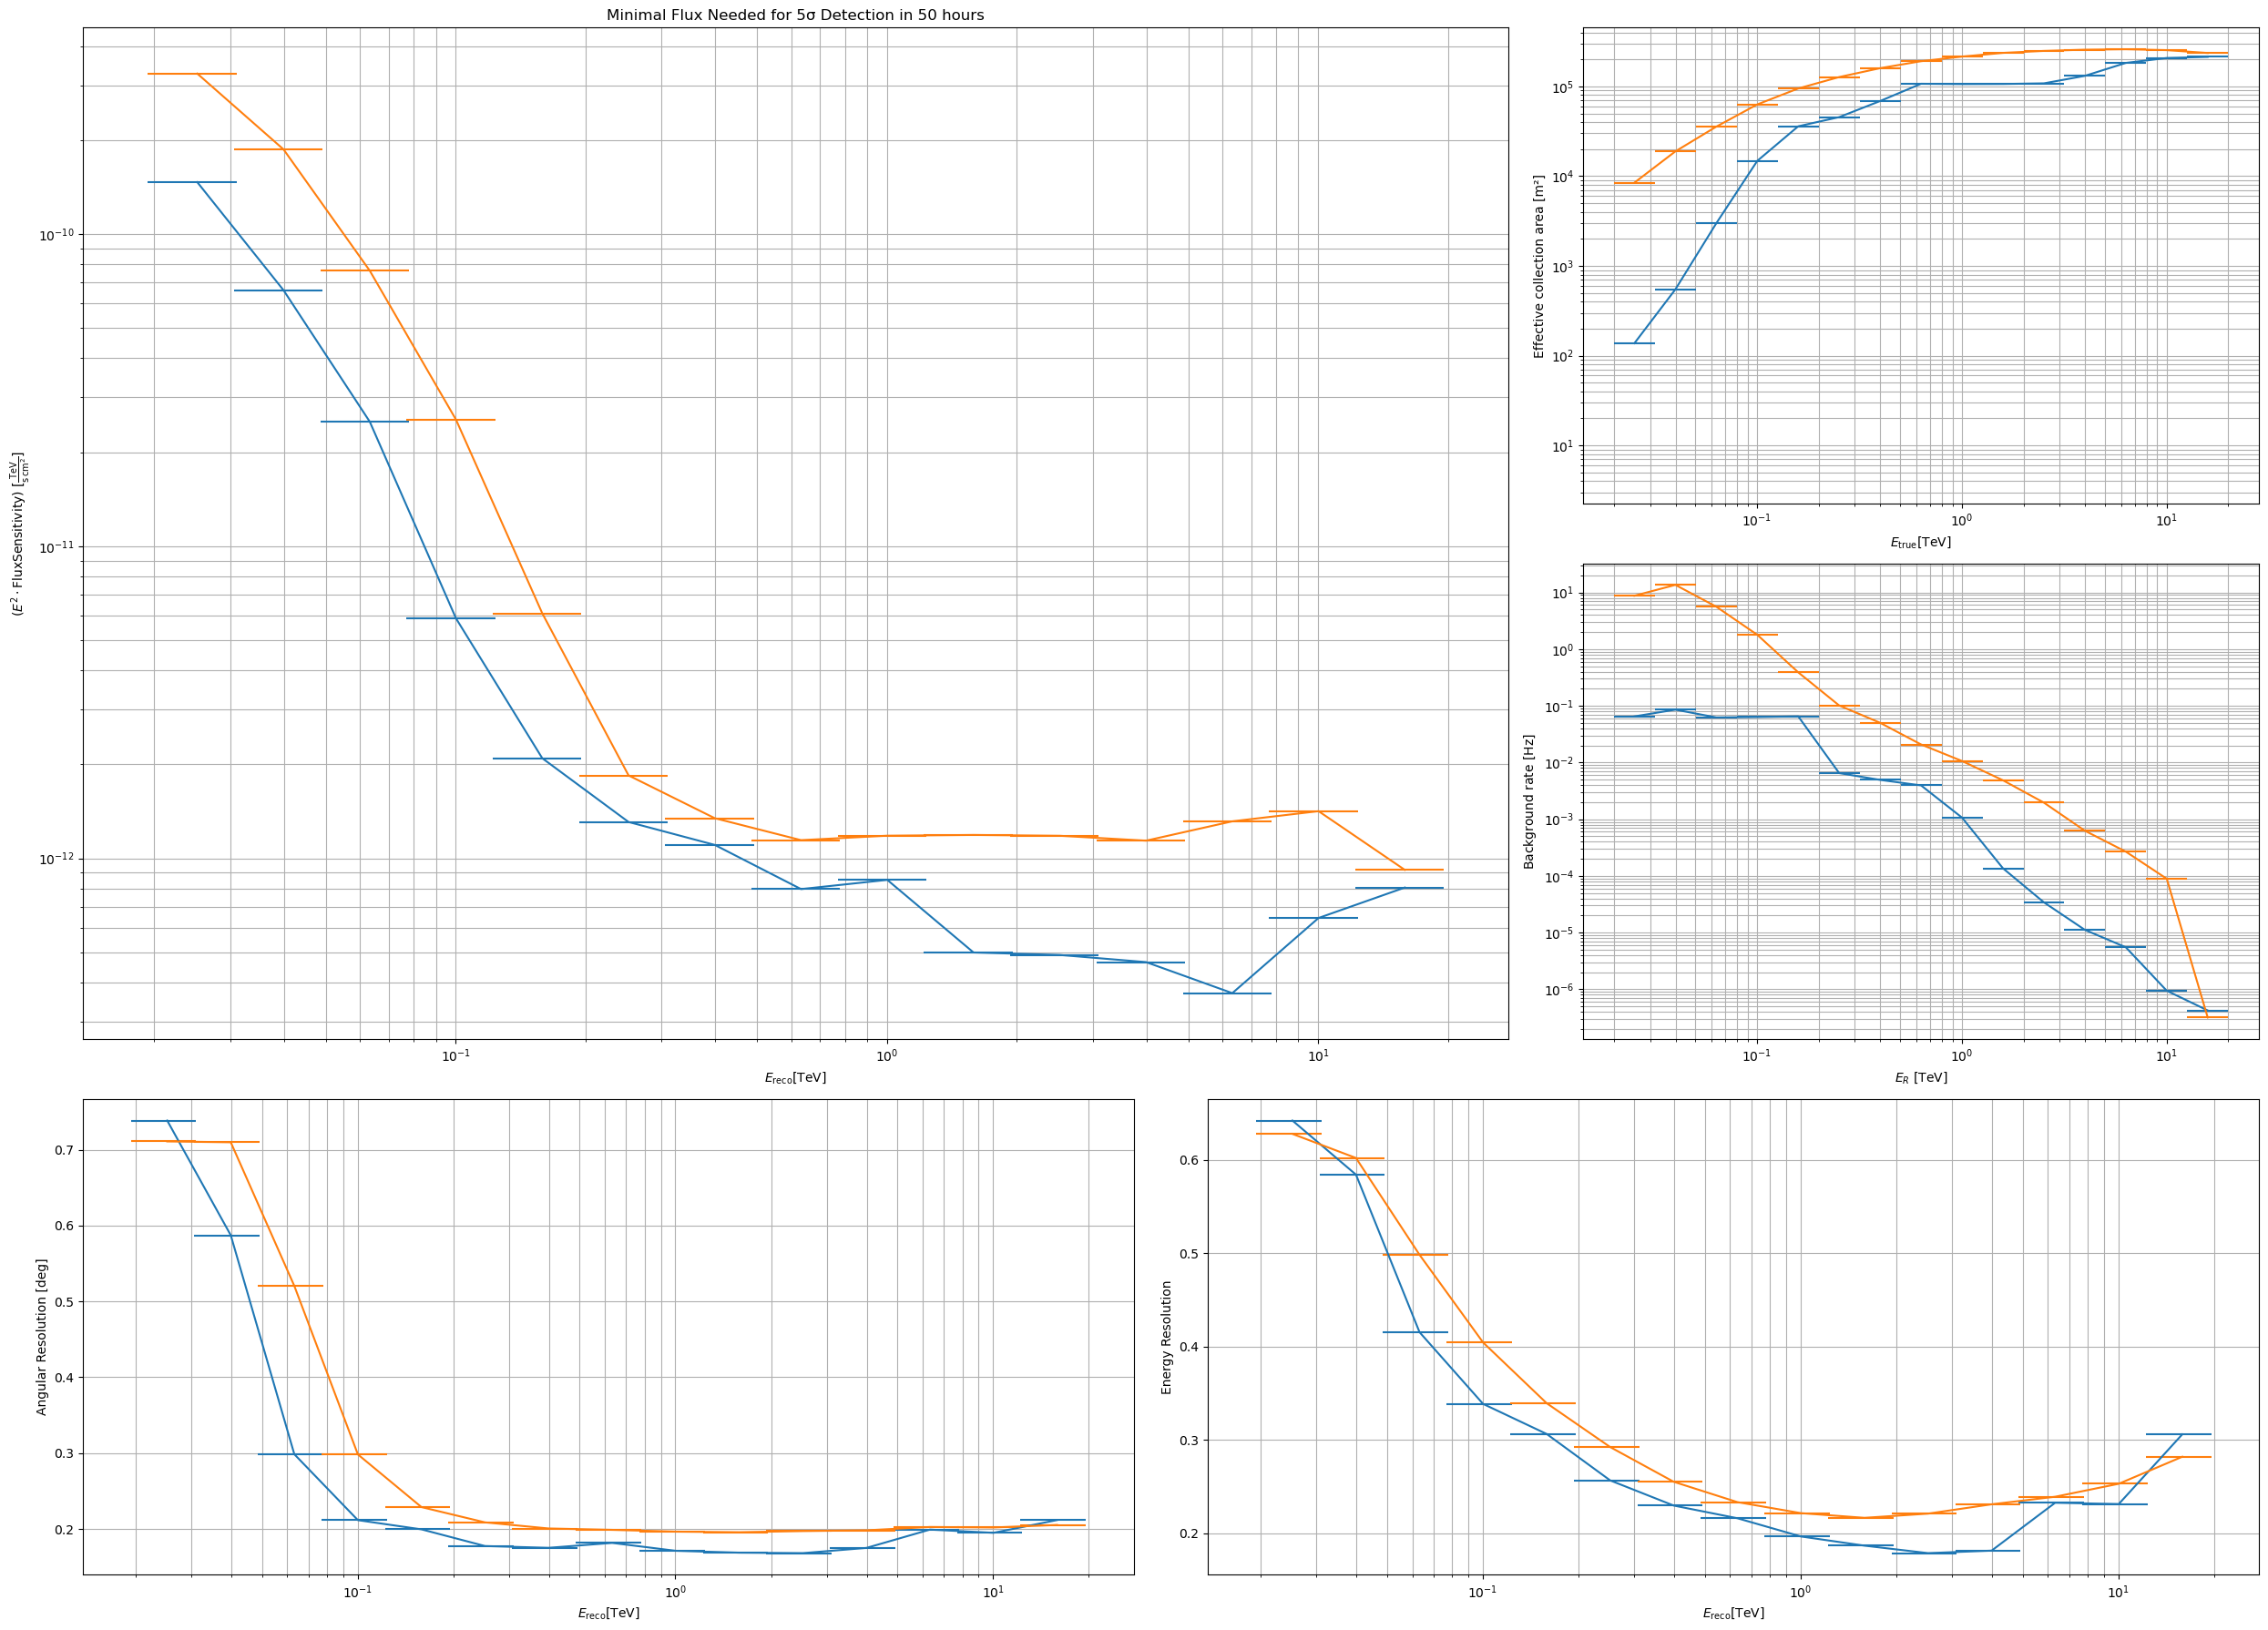

In [10]:
from matplotlib import pyplot as plt
from astropy.table import QTable
import astropy.units as u
import numpy as np
import pandas as pd
import sklearn.metrics
from pyirf.utils import cone_solid_angle


pyirf_files = ["../data/IRFs/LST1_cleanedTRN_DeepCrab_theta_10.0_az_102.199_optimized_sensitivity.fits.gz", \
               "../data/IRFs/LST1_cleanedTRN_DeepCrab_theta_10.0_az_102.199_gammaefficency0.7.fits.gz"]

fig = plt.figure(figsize=(25,18))

ax1 = plt.subplot2grid((6, 6), (0, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((6, 6), (0, 4), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((6, 6), (2, 4), colspan=2, rowspan=2)
ax4 = plt.subplot2grid((6, 6), (4, 0), colspan=3, rowspan=2)
ax5 = plt.subplot2grid((6, 6), (4, 3), colspan=3, rowspan=2)
    
axes = [ax1, ax2, ax3, ax4, ax5]


for file in pyirf_files:
    
    # Flux sensitivity
    sensitivity_table = QTable.read(file, hdu='SENSITIVITY')[1:-1]
    
    energy_low = np.array(sensitivity_table['reco_energy_low'].to_value(u.TeV))
    energy_high = np.array(sensitivity_table['reco_energy_high'].to_value(u.TeV))
    energy_center = np.sqrt(energy_low * energy_high)
    ewidth = energy_high - energy_low
    
    sensitivity = (energy_center ** 2 * sensitivity_table['flux_sensitivity'])
    
    ax1.errorbar(
        energy_center,
        sensitivity,
        xerr=ewidth/2,
    )

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True, which='both')

    ax1.set_title('Minimal Flux Needed for 5σ Detection in 50 hours')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel(r'$E_\mathrm{reco} [\mathrm{TeV}]$')
    sens_unit = u.Unit('TeV cm-2 s-1')
    ax1.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}})$ [{sens_unit.to_string('latex')}]")

    # Effective area
    area = QTable.read(file, hdu='EFFECTIVE_AREA')[0]
    energy_center = np.sqrt(area['ENERG_LO'][1:-1] * area['ENERG_HI'][1:-1])
    ax2.errorbar(energy_center.to_value(u.TeV),
        area['EFFAREA'].T[1:-1, 0].to_value(u.m ** 2),
        xerr=((energy_center-area['ENERG_LO'][1:-1]).to_value(u.TeV), (area['ENERG_HI'][1:-1]-energy_center).to_value(u.TeV)),
    )
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.set_xlabel(r'$E_\mathrm{true} [\mathrm{TeV}]$')
    ax2.set_ylabel("Effective collection area [m²]")
    ax2.grid(True, which='both')
    
    
    # Background rate
    rad_max = QTable.read(file, hdu='RAD_MAX')[0]
    bg_rate = QTable.read(file, hdu='BACKGROUND')[0]

    reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

    # first fov bin, [0, 1] deg
    fov_bin = 0
    rate_bin = bg_rate['BKG'].T[:, fov_bin]

    # interpolate theta cut for given e reco bin
    e_center_bg = np.sqrt(bg_rate['ENERG_LO'] * bg_rate['ENERG_HI'])
    e_center_theta = np.sqrt(rad_max['ENERG_LO'] * rad_max['ENERG_HI'])
    theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

    # undo normalization
    rate_bin *= cone_solid_angle(theta_cut)
    rate_bin *= np.diff(reco_bins)

    energy_low = bg_rate['ENERG_LO'][1:-1]
    energy_high = bg_rate['ENERG_HI'][1:-1]
    background_rate = rate_bin[1:-1]

    energy_center = np.sqrt(energy_low * energy_high)
    ax3.errorbar(e_center, background_rate.to(u.Hz), xerr=[energy_center-energy_low, energy_high-energy_center])

    ax3.set_xlabel(fr"$E_R$ [{energy_center.unit.to_string('latex')}]")
    ax3.set_ylabel(f"Background rate [{background_rate.to(u.Hz).unit.to_string('latex')}]")
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    ax3.grid(True, which='both')
    
    # Angular resolution
    ang_res = QTable.read(file, hdu='ANGULAR_RESOLUTION')[1:-1]    
    energy_low = np.array(ang_res['reco_energy_low'].to_value(u.TeV))
    energy_high = np.array(ang_res['reco_energy_high'].to_value(u.TeV))
    angular_resolution = np.array(ang_res['angular_resolution'].to_value(u.deg))
    energy_center = np.sqrt(energy_low * energy_high)
    ewidth = energy_high - energy_low
    
    ax4.errorbar(
        energy_center,
        angular_resolution,
        xerr=ewidth/2
    )

    ax4.set_xscale("log")
    ax4.set_xlabel(r'$E_\mathrm{reco} [\mathrm{TeV}]$')
    ax4.set_ylabel("Angular Resolution [deg]")
    ax4.grid(True, which="both")
    
    # Energy resolution        
    en_res = QTable.read(file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]    
    energy_low = np.array(en_res['reco_energy_low'].to_value(u.TeV))
    energy_high = np.array(en_res['reco_energy_high'].to_value(u.TeV))
    energy_resolution = np.array(en_res['resolution'])
    energy_center = np.sqrt(energy_low * energy_high)
    ewidth = energy_high - energy_low
    
    ax5.errorbar(
        energy_center,
        energy_resolution,
        xerr=ewidth/2
    )

    ax5.set_xscale("log")
    ax5.set_xlabel(r'$E_\mathrm{reco} [\mathrm{TeV}]$')
    ax5.set_ylabel("Energy Resolution")
    ax5.grid(True, which="both")

plt.tight_layout()
plt.show()


